In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(self.hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        
        return predictions[-1]
        #return predictions

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [5]:
data = np.loadtxt("./lienard_intermittency.dat")

Text(0, 0.5, 'y')

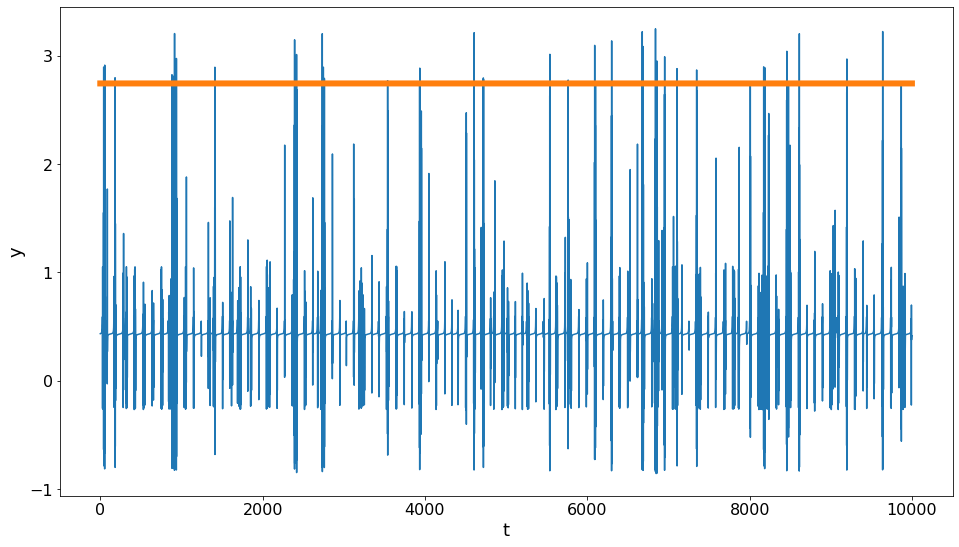

In [16]:
csfont = {'fontsize': 18}
plt.figure(figsize=(16, 9))
plt.plot(data[:, 1][:10000])
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(list(range(10000)), [mean + 8*std for _ in range(10000)], linewidth = 6)
plt.xlabel('t', **csfont)
plt.ylabel('y', **csfont)

In [7]:
train = data[:, 1][:40000]
test =  data[:, 1][40000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

In [20]:
past_res = [-0.27 if i%2 else -0.91 for i in range(len(test_norm))]

Text(0, 0.5, 'x')

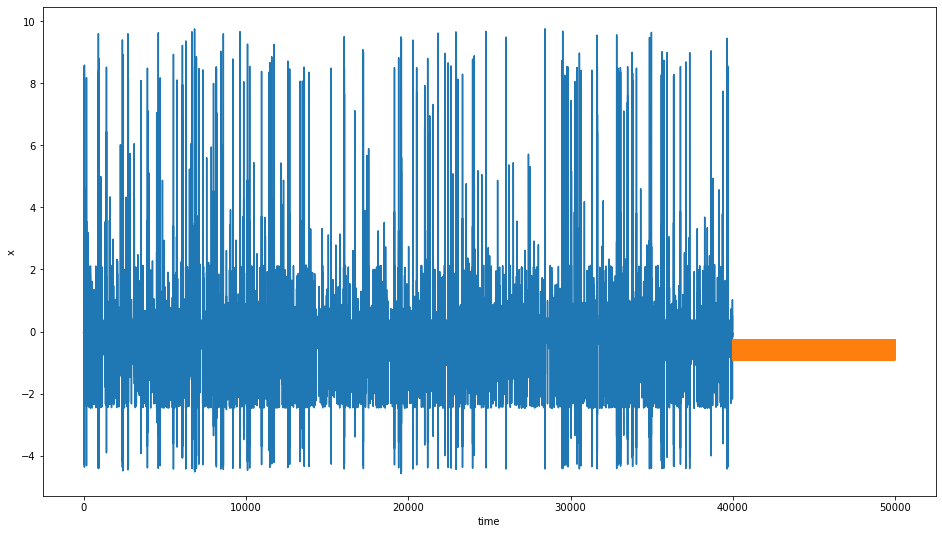

In [27]:
plt.figure(figsize=(16, 9))
plt.plot(train_norm)
plt.plot(range(40000, 40000+len(past_res)), past_res)
plt.xlabel('time')
plt.ylabel('x')

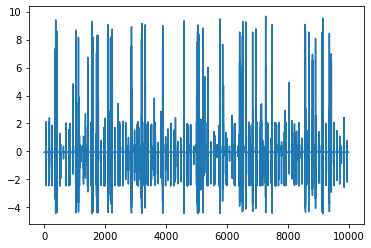

In [19]:
plt.figure(figsize=(16, 9))
plt.plot(test_norm)
plt.xlabel('time')
plt.ylabel('x')

In [8]:
train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [9]:
train_window = 120

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [10]:
train_inout_seq = create_inout_sequences(train_norm, train_window)

In [11]:
from IPython.display import clear_output

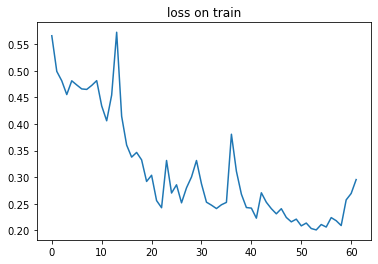

0.2955291213090496


KeyboardInterrupt: 

In [15]:
epochs = 250
model = LSTM().to('cuda')
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
losses = []
model.train()
for i in range(epochs):
    if i> 0 and i % 10 == 0:
        learning_rate *= 0.5
    epoch_loss = []
    for seq, label in train_inout_seq:
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        y_pred = model(seq.to('cuda'))

        single_loss = nn.MSELoss()(y_pred, label.to('cuda'))
        single_loss.backward()
        optimizer.step()
        epoch_loss.append(single_loss.item())

        
    clear_output(True)
    losses.append(np.mean(epoch_loss))
    plt.title("loss on train")
    plt.plot(losses)
    plt.show()
    print(losses[-1])
    

#print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


In [16]:
fut_pred = 1000

test_inputs = train_norm[-train_window:].tolist()
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to('cuda')
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        test_inputs.append(model(seq).item())

In [28]:
torch.save(model.state_dict(), './eemodel')

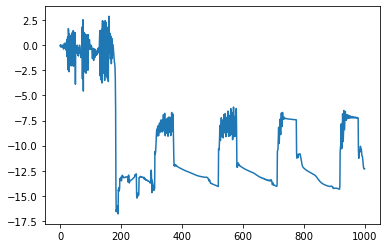

In [17]:
plt.plot(test_inputs[120:])

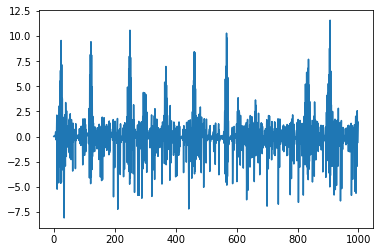

In [14]:
plt.plot(test_inputs[120:])

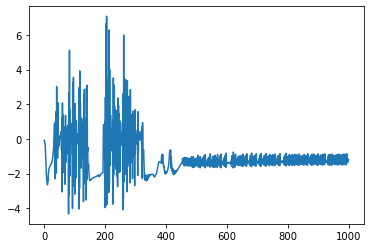

In [31]:
plt.plot(test_inputs[40:])

In [60]:
fut_pred = 1000

test_inputs = train_norm[-train_window:].tolist()
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).to('cuda')
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        test_inputs.append(model(seq).item())

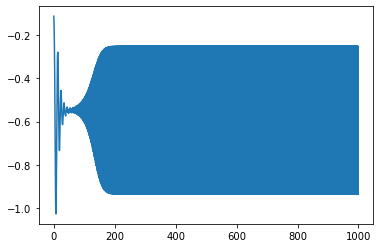

In [61]:
plt.plot(test_inputs[120:])

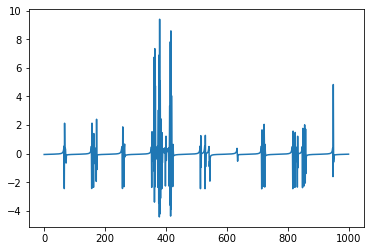

In [58]:
plt.plot(test_norm[:1000])

In [33]:
def test_window_size(size):
    train_inout_seq = create_inout_sequences(train_norm, size)
    epochs = 18
    model = LSTM().to('cuda')
    learning_rate = 0.005
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    losses = []
    for i in range(epochs):
        epoch_loss = []
        if i > 150:
            learning_rate *= 0.2
        for seq, label in train_inout_seq:
            optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                            torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
            y_pred = model(seq.to('cuda'))

            single_loss = nn.MSELoss()(y_pred, label.to('cuda'))
            single_loss.backward()
            optimizer.step()
            epoch_loss.append(single_loss.item())


        clear_output(True)
        losses.append(np.mean(epoch_loss))
        plt.title("loss on train")
        plt.plot(losses)
        plt.show()
        print(losses[-1])


    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    
    
    fut_pred = 1000

    test_inputs = train_norm[-size:].tolist()
    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-size:]).to('cuda')
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                            torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
            test_inputs.append(model(seq).item())
    plt.plot(test_inputs)

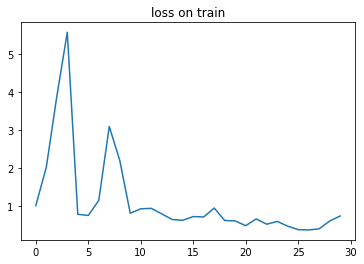

0.7474388432898594
epoch:  29 loss: 0.0551261343


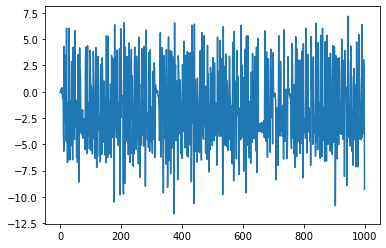

In [31]:
test_window_size(1)

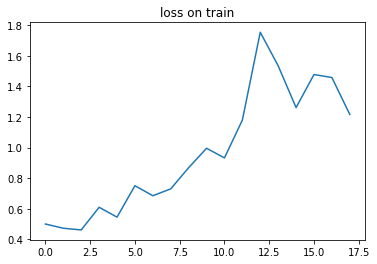

1.2171268622926315
epoch:  17 loss: 0.2585898638


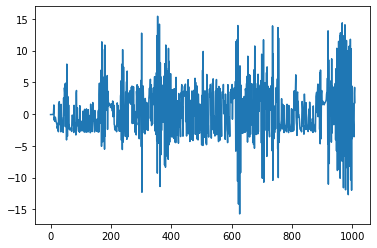

In [34]:
test_window_size(10)

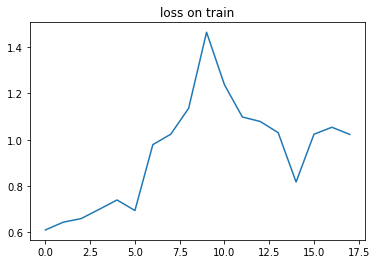

1.023070081363337
epoch:  17 loss: 0.0624940693


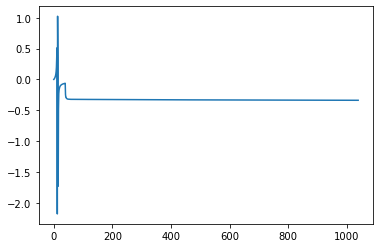

In [35]:
test_window_size(40)

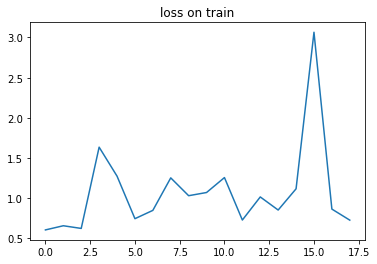

0.727673639790242
epoch:  17 loss: 0.0072121536


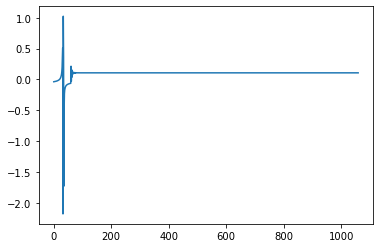

In [36]:
test_window_size(60)

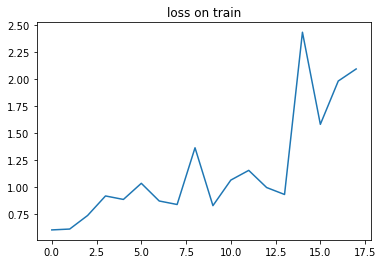

2.0931188346358254
epoch:  17 loss: 0.2569960952


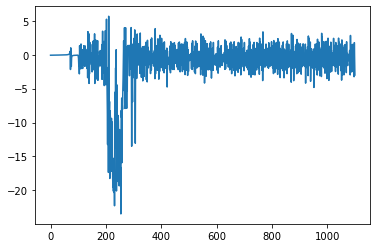

In [37]:
test_window_size(100)

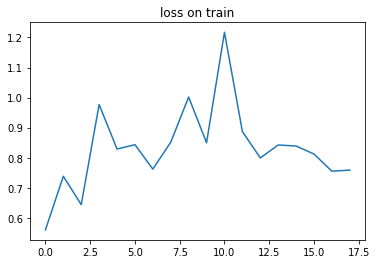

0.7587979837175016
epoch:  17 loss: 0.0464244522


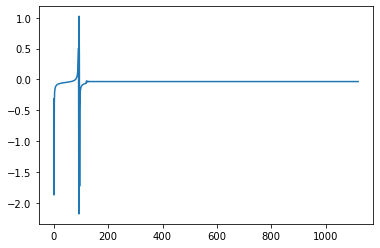

In [38]:
test_window_size(120)

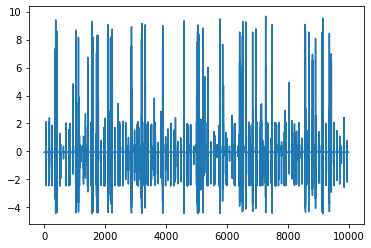

In [39]:
plt.plot(test_norm)

In [19]:
test_inputs[100:]

[0.7522785663604736,
 0.7695643901824951,
 0.7714860439300537,
 0.771611213684082,
 0.7716188430786133,
 0.7716202735900879,
 0.7716217041015625,
 0.7716226577758789,
 0.7716236114501953,
 0.7716240882873535,
 0.7716245651245117,
 0.7716255187988281,
 0.7716259956359863,
 0.7716264724731445,
 0.7716264724731445,
 0.7716269493103027,
 0.7716274261474609,
 0.7716274261474609,
 0.7716274261474609,
 0.7716274261474609]

In [22]:
true_evol = train_norm

In [250]:
len(true_evol)

10118

In [20]:
model_test = LSTM()
model_test.load_state_dict(model.state_dict())
model_test.to('cuda')
model_test.hidden_cell = (torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'))

In [23]:
predicted = []

for step in range(0, len(test_norm), train_window):
    fut_pred = 20
    true_evol_per_step = test_norm[step: step + train_window]
    test_inputs = true_evol[-train_window:].tolist()
    model_test.eval()
    
    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:]).to('cuda')
        with torch.no_grad():
            model_test.hidden = (torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'),
                            torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'))
            test_inputs.append(model_test(seq).item())
    predicted += test_inputs[train_window:]
    
    if len(true_evol_per_step) == train_window:
        model_test.train()
        test_inout_seq = create_inout_sequences(true_evol_per_step, train_window)
        for seq, labels in test_inout_seq:
            optimizer.zero_grad()
            model_test.hidden_cell = (torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'),
                                torch.zeros(1, 1, model_test.hidden_layer_size).to('cuda'))
            y_pred = model_test(seq.to('cuda'))

            single_loss = nn.MSELoss()(y_pred, labels.to('cuda'))
            single_loss.backward()
            optimizer.step()
    true_evol = torch.cat((true_evol, true_evol_per_step))

In [252]:
len(true_evol)

12400

In [272]:
predicted

[-0.7481163740158081,
 -0.7873939275741577,
 -0.8003643751144409,
 -0.80268394947052,
 -0.797538161277771,
 -0.7849761247634888,
 -0.7615900039672852,
 -0.7265242338180542,
 -0.6801971197128296,
 -0.6248399019241333,
 -0.5638436079025269,
 -0.5021533966064453,
 -0.4456915855407715,
 -0.4000328779220581,
 -0.3678485155105591,
 -0.3475431203842163,
 -0.3319512605667114,
 -0.3095458745956421,
 -0.27318692207336426,
 -0.22408998012542725,
 7.414846897125244,
 7.431535243988037,
 7.4292192459106445,
 7.4284820556640625,
 7.428896903991699,
 7.428886890411377,
 7.428887844085693,
 7.42888879776001,
 7.42583703994751,
 6.435214042663574,
 6.399441719055176,
 5.8740644454956055,
 5.773513317108154,
 5.774921417236328,
 4.922274589538574,
 4.55006742477417,
 4.330643653869629,
 4.187145709991455,
 4.095348834991455,
 4.021570205688477,
 -2.5917673110961914,
 -2.5833373069763184,
 -2.5690650939941406,
 -2.556260108947754,
 -2.550281524658203,
 -2.524178981781006,
 -2.4002599716186523,
 -2.164083

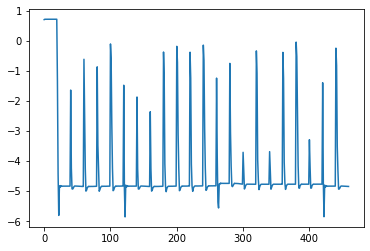

In [24]:
plt.plot(predicted)

In [288]:
predicted[540:600]

[0.7254955768585205,
 0.759441077709198,
 0.8165570497512817,
 0.9066677689552307,
 1.0596500635147095,
 1.3597785234451294,
 2.053805351257324,
 3.542520523071289,
 5.817389011383057,
 7.216159820556641,
 7.410839557647705,
 7.430907726287842,
 7.428900718688965,
 7.428427696228027,
 7.42883825302124,
 7.428889274597168,
 7.428878307342529,
 7.428896903991699,
 7.428868770599365,
 7.428895950317383,
 7.364964485168457,
 7.422447681427002,
 7.4313249588012695,
 7.429101467132568,
 7.428415298461914,
 6.4967942237854,
 6.403209209442139,
 6.394354820251465,
 5.8704328536987305,
 5.772806644439697,
 5.774835586547852,
 5.771492004394531,
 5.772113800048828,
 4.77903413772583,
 4.435580730438232,
 4.254242420196533,
 4.127035140991211,
 4.041009426116943,
 4.017014503479004,
 4.00699520111084,
 -2.221782684326172,
 -2.3046770095825195,
 -2.378777503967285,
 -2.4135990142822266,
 -2.271876811981201,
 -2.0543274879455566,
 -1.7386926412582397,
 -1.556733250617981,
 -1.5152684450149536,
 -1.

In [255]:
len(predicted)

2300

In [256]:
(len(test))

2282

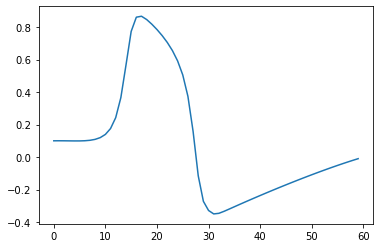

In [275]:
plt.plot(test[540:600])

In [233]:
train_norm.max()

tensor(7.2043)

In [17]:
train_norm[6000:6500].max()

tensor(0.7050)

In [15]:
test_inputs[20:40]

[0.616908073425293,
 0.6662673950195312,
 0.7360585927963257,
 0.8477460145950317,
 1.0375640392303467,
 1.382082462310791,
 2.077755928039551,
 3.553882360458374,
 5.988043308258057,
 7.623494625091553,
 7.865307807922363,
 7.769824504852295,
 7.305576801300049,
 6.853262901306152,
 6.533700942993164,
 6.257808208465576,
 5.98073148727417,
 5.655295372009277,
 5.201878547668457,
 4.45725679397583]

In [16]:
test_inputs

[-0.809381902217865,
 -0.7330803871154785,
 -0.6515586376190186,
 -0.5671824216842651,
 -0.48149025440216064,
 -0.39551928639411926,
 -0.31000402569770813,
 -0.2254968136548996,
 -0.142441987991333,
 -0.0612218864262104,
 0.017813704907894135,
 0.09432881325483322,
 0.16798919439315796,
 0.238455131649971,
 0.3053778409957886,
 0.368399441242218,
 0.427156001329422,
 0.4812846779823303,
 0.5304350256919861,
 0.5742854475975037,
 0.616908073425293,
 0.6662673950195312,
 0.7360585927963257,
 0.8477460145950317,
 1.0375640392303467,
 1.382082462310791,
 2.077755928039551,
 3.553882360458374,
 5.988043308258057,
 7.623494625091553,
 7.865307807922363,
 7.769824504852295,
 7.305576801300049,
 6.853262901306152,
 6.533700942993164,
 6.257808208465576,
 5.98073148727417,
 5.655295372009277,
 5.201878547668457,
 4.45725679397583]

In [57]:
np.max(test_inputs[:60])

7.430398941040039

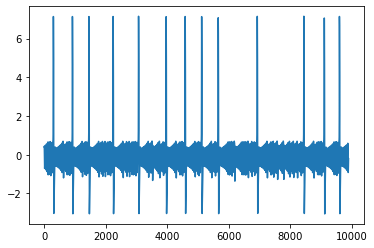

In [67]:
plt.plot(train_norm)

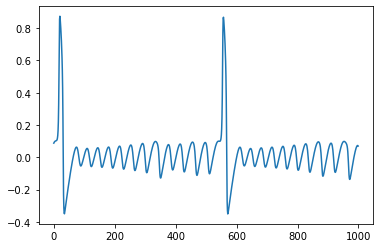

In [44]:
plt.plot(test[:1000])

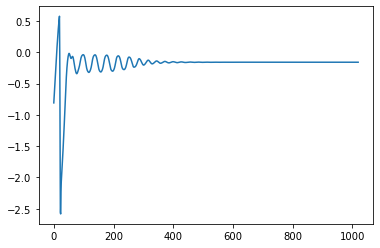

In [43]:
plt.plot(test_inputs)

In [38]:
losses = []
model = LSTM()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
for epoch in range(20):
    for x, y in zip(X_train, Y_train):
        optimizer.zero_grad()
        x = torch.from_numpy(np.expand_dims(np.array([x]), axis=0)).type(torch.FloatTensor)
        y = torch.from_numpy(np.expand_dims(np.array([y]), axis=0)).type(torch.FloatTensor)
        y_pred = model(x)
        loss = nn.MSELoss()(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        plt.plot(range(len(losses)), losses)
        plt.ylabel("loss")
        plt.xlabel("epochs")

RuntimeError: input must have 3 dimensions, got 2